# PAS-MARIOTT: solution design for region scanning optimisation
## 1. initialise the environment and define basic functions

In [1]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import random
import itertools
import copy
import os
import imp
import json

from scipy import interpolate
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from scipy.spatial import ConvexHull, convex_hull_plot_2d

import MissionScenario
import MissionPlan
import ZoningProblem
import utils

from sklearn.cluster import KMeans
from collections import defaultdict
from utils import *

imp.reload(utils)
imp.reload(MissionScenario)
#imp.reload(MissionPlan)
imp.reload(ZoningProblem)
from MissionScenario import MissionScenario as Scenario
from ZoningProblem import ZoningSolution, ZoningAlgorithm, RoutingAlgorithm
#from MissionPlan import MissionPlan, MissionPath

#from jupyterthemes import jtplot
#jtplot.style()

hexcolours = ['#000000',
  '#6efa88',
  '#6ec7fa',
  '#f86efa',
  '#fac06e',
  '#fa6e6e',
  '#6efa88',
  '#6ec7fa',
  '#f86efa',
  '#fac06e',
  '#fa6e6e',
]


/tmp/ipykernel_92597/92127699.py:11: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


## 2. Load scenario (option A)

## 2. Generate scenario (option B)

In [2]:
# add scenario params:
# - min distance base-centre
# - min distance exit-centre

# separation segment params
#sep_min, sep_max, sep_step = -1.5, 1.11, 0.1
# scenario params
dist_start = 120
dist_end = -30
nb_agents = 4
scenario_id = '1'

#scenario = Scenario.generate(dist_base_centre=dist_start, dist_exit_centre=dist_end, nb_agents=nb_agents, 
#                             sep_min=sep_min, sep_max=sep_max, sep_step=sep_step)

scenario = Scenario.generate(dist_base_centre=dist_start, dist_exit_centre=dist_end, \
                             nb_agents=nb_agents, nb_clusters=6)

#scenario = Scenario.generate(120, -50, 6)

# todo this is temporary
#scenario.base = (100,20)
#scenario.exit = (120,240)
print("Initial zoning:", scenario.zoning_sol)
#scenario.priorities

Initial zoning: [1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1]



/tmp/ipykernel_92597/1795741267.py:51: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x[i], y[i], cmap='viridis', color='#009496', s=5*p[i])


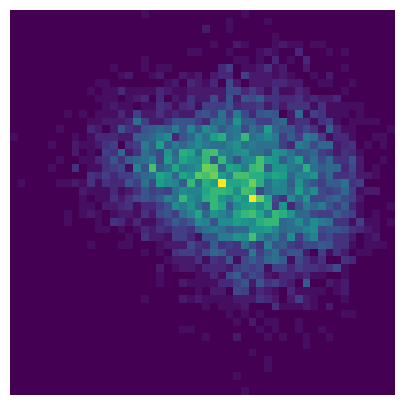

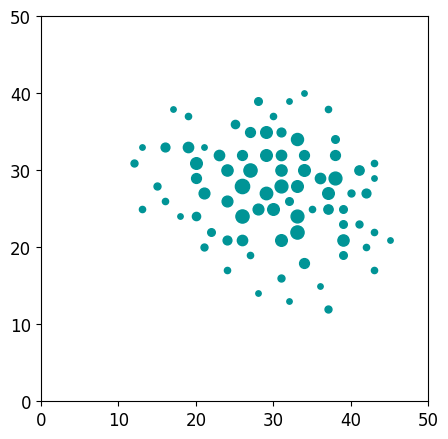

In [3]:
heatmap = scenario.heatmap

# plot map (heatmap)
fig = plt.figure(figsize=(5, 5))
fig.add_subplot(111)
img = np.transpose(heatmap)
img = np.flip(img,0)
plt.axis('off')

plt.imshow(img, origin='upper')

'''
fig.add_subplot(1, 2, 2)
plt.imshow(targets, extent=extent, origin='upper')
plt.show()
'''
fig.savefig('results/example-heatmap.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)



# plot targets
data_mean = np.mean(heatmap[heatmap>0])

targets = np.zeros((50,50), dtype=int)
for i in range(1,targets.shape[0]-1):
  for j in range(1,targets.shape[1]-1):
    if (heatmap[i,j]>data_mean/2 and np.random.rand()<.2):
      targets[i,j] = heatmap[i,j] #heatmap[i,j]
    if (targets[i-1,j]>0 or targets[i+1,j]>0 or targets[i,j-1]>0 or targets[i,j+1]>0 or 
        targets[i-1,j-1]>0 or targets[i+1,j-1]>0 or targets[i-1,j+1]>0 or targets[i+1,j+1]>0 ):
      targets[i,j] = 0

# generate targets
x, y, p = [],[],[]
for i in range(0, targets.shape[0]):
  for j in range(0, targets.shape[1]):
    if (targets[i,j] > 0):
      x.append(i)
      y.append(j)
      p.append(targets[i,j])

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.grid(False)
plt.xlim([0, 50])
plt.ylim([0, 50])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for i in range(len(x)):
  ax.scatter(x[i], y[i], cmap='viridis', color='#009496', s=5*p[i])

fig.savefig('results/example-network.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)


centroid: (39180.204460966546, 127531.30483271375)
Internal radius: 20767.707284239


/tmp/ipykernel_92597/1809163214.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x[i], y[i], cmap='viridis', color='#009496', s=4*p)


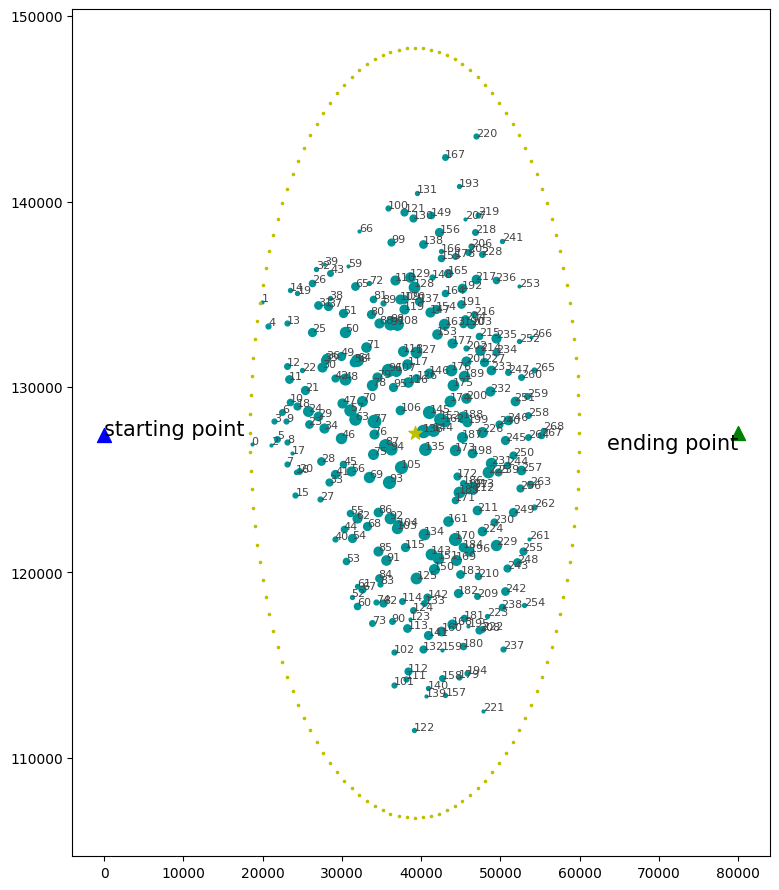

In [4]:
# important local vars
x = scenario.targets_x
y = scenario.targets_y
nb_targets = scenario.nb_targets
(xb, yb) = scenario.base
(xn, yn) = scenario.exit
(xe, ye) = scenario.centroid
print('centroid:', (xe, ye) )
Re = scenario.radius_internal
print('Internal radius:', Re)
# -------------------------------
fig = plt.figure()
fig.set_size_inches(9, 11)
ax = fig.add_subplot(111)
ax.grid(False)
# plot base station
ax.scatter(xb, yb, color='b', marker='^', s=100)
ax.text(xb, yb, 'starting point', size=15, zorder=1, color='k')
# plot next station
ax.scatter(xn, yn, color='g', marker='^', s=100)
ax.text(xn, yn, 'ending point', size=15, zorder=2, color='k', 
        horizontalalignment='right',verticalalignment='top')

# plot targets
for i in range(len(x)):
  p = scenario.priorities[i]
  ax.scatter(x[i], y[i], cmap='viridis', color='#009496', s=4*p)
  ax.text(x[i], y[i], str(i), size=8, color='#444')

# plot overall centroid
ax.scatter(xe, ye, color='y', marker='*', s=100)
#ax.scatter(scenario.centroid[0], scenario.centroid[1], color='g', s=100, marker='*')

# sample points around safety circle:
for v in np.arange(0, 2*math.pi, math.pi/64.0):
  rnd = np.random.rand()
  theta = math.pi + v
  tx = xe + Re * math.cos(theta)
  ty = ye + Re * math.sin(theta)
  ax.scatter(tx, ty, color='y', marker='.', s=10)
# -------------------------------

'''
# extract convex envolope
targets = np.array(list(map(list, scenario.targets)))
hull = ConvexHull(targets)
print(targets[hull.simplices])

for simplex in hull.simplices:
  print('>>> ',targets[simplex, 0], targets[simplex, 1])
  ax.plot(targets[simplex, 0], targets[simplex, 1], 'y-')
'''

fig.savefig('results/scenario'+scenario_id+'-instance.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)

#fig

## 3. create zoning scheme

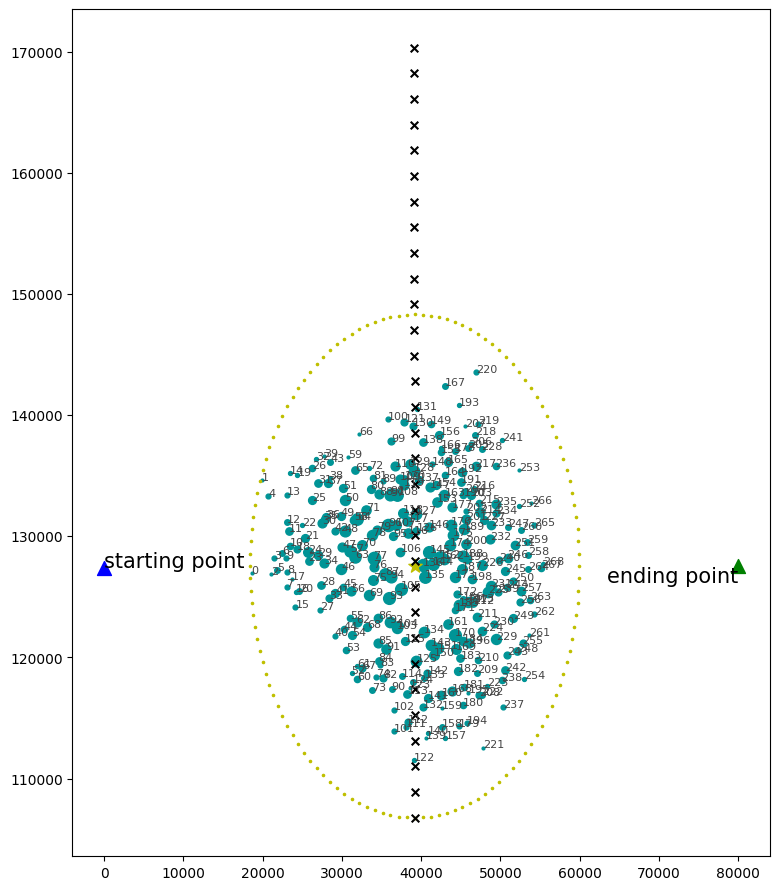

In [5]:
# -------------------------------
# calculate threat region
# -------------------------------
SR = scenario.radius_internal

ax.scatter(scenario.sep_waypoints_x, scenario.sep_waypoints_y, color='k', marker='x', s=30)

fig.savefig('results/scenario'+scenario_id+'-sep-points.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)

fig
# -------------------------------

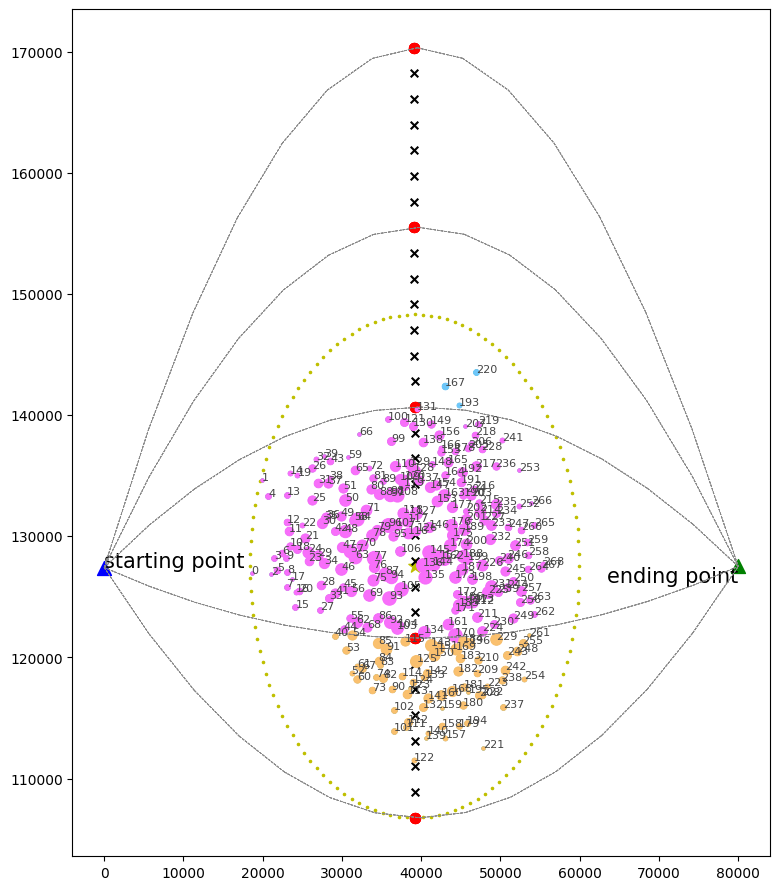

In [6]:
'''
node_zone = np.zeros(scenario.nb_targets, dtype=int)
for j in range(scenario.nb_targets):
  for i in range(1, scenario.nb_agents+1):
    zone = scenario.separators[i-1] + scenario.separators[i][::-1]
    node = scenario.targets[j]
    point = Point(node)
    polygon = Polygon(zone)
    if polygon.contains(point):
      node_zone[j] = i

zones = defaultdict(list)
for i in range(scenario.nb_targets):
  zones[node_zone[i]].append(i)
'''


nb_separators = scenario.nb_agents + 1
nb_wp = len(scenario.sep_waypoints_x)

# -------------------------------
for i in range(nb_separators):
  for j in range(nb_wp):
    if scenario.zoning_sol.solution[j]==1:
      ax.scatter(scenario.sep_waypoints_x[j], scenario.sep_waypoints_y[j], color='r', marker='o', s=50)
      # plot separators
      sep = scenario.zoning_sol.separators[i]

      for j in range(len(sep)-1):
        p1 = sep[j]
        p2 = sep[j+1]
        xline = (p1[0], p2[0])
        yline = (p1[1], p2[1])
        #ax.plot(xline, yline, linestyle = '--', color='b', linewidth=.7)
        ax.plot(xline, yline, linestyle = '--', color='#888', linewidth=.5)
# -------------------------------

# -------------------------------
ZZ = scenario.zoning_sol

for zone_id, nodes in ZZ.zones.items():
  
  #rnd = lambda: random.randint(0,255)
  #hexcolour=('#%02X%02X%02X' % (rnd(),rnd(),rnd()))
  for node in nodes:
    p = scenario.priorities[node]
    ax.scatter(x[node], y[node], c=hexcolours[zone_id], s=p*5)
# -------------------------------
fig.savefig('results/scenario'+scenario_id+'-init-zones.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)
fig

In [7]:
algo = ZoningAlgorithm(scenario)
[zoning_sol, envelope] = algo.search()

Iteration 2 - coverage: 19.55


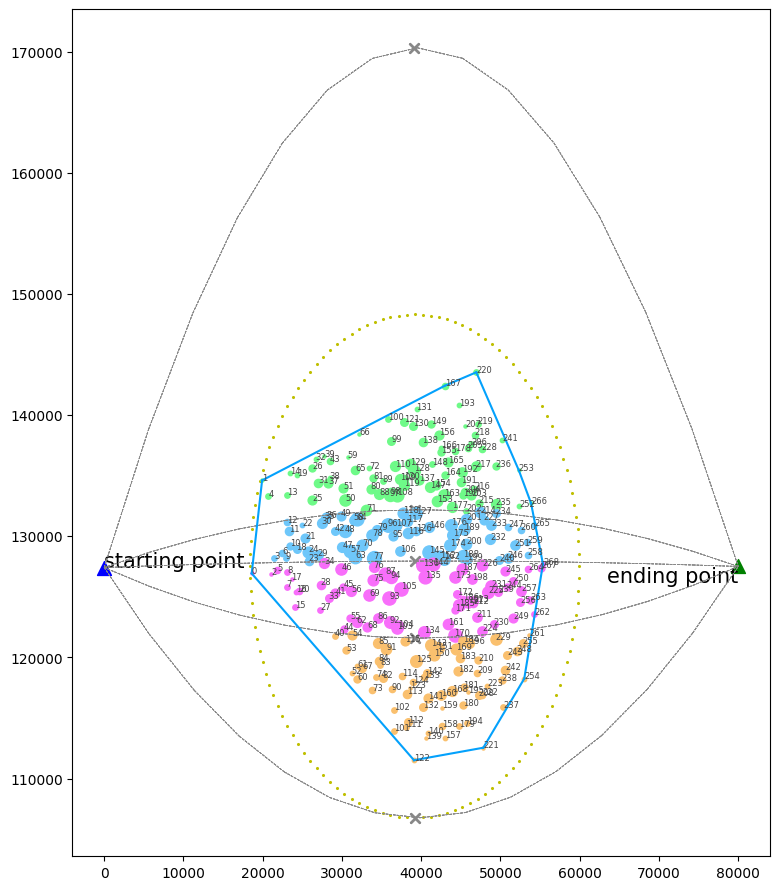

In [8]:
imp.reload(ZoningProblem)
from ZoningProblem import ZoningSolution, ZoningAlgorithm, RoutingAlgorithm

ax.cla()
#=====================================
# REPLOT LATEST SOLUTION:
#=====================================
#zoning_sol = scenario.zoning_sol
fig = plt.figure()
fig.set_size_inches(9, 11)
ax = fig.add_subplot(111)
ax.grid(False)
# plot base station
ax.scatter(xb, yb, color='b', marker='^', s=100)
ax.text(xb, yb, 'starting point', size=15, zorder=1, color='k')
# plot next station
ax.scatter(xn, yn, color='g', marker='^', s=100)
ax.text(xn, yn, 'ending point', size=15, zorder=2, color='k', 
        horizontalalignment='right',verticalalignment='top',)

# sample points around safety circle:
for v in np.arange(0, 2*math.pi, math.pi/64.0):
  rnd = np.random.rand()
  theta = math.pi + v
  tx = xe + Re * math.cos(theta)
  ty = ye + Re * math.sin(theta)
  ax.scatter(tx, ty, color='y', marker='.', s=6)

nb_separators = scenario.nb_agents + 1

for i in range(nb_separators):
  for j in range(scenario.nb_wp):
    if zoning_sol.solution[j]==1:
      ax.scatter(scenario.sep_waypoints_x[j], scenario.sep_waypoints_y[j], color='#888', marker='x', s=50)
      # plot separators
      sep = zoning_sol.separators[i]

      for j in range(len(sep)-1):
        p1 = sep[j]
        p2 = sep[j+1]
        xline = (p1[0], p2[0])
        yline = (p1[1], p2[1])
        ax.plot(xline, yline, linestyle = '--', color='#888', linewidth=.5)

for zone_id, nodes in zoning_sol.zones.items():
  for node in nodes:
    p = scenario.priorities[node]
    ax.scatter(x[node], y[node], c=hexcolours[zone_id], s=p*5)
    ax.text(x[node], y[node], node, size=6, color='#444')

#=====================================

# plot coverage envelope
for line in envelope:
  ax.plot([line[0][0],line[1][0]], [line[0][1],line[1][1]], c='#03a1fc')

#=====================================
fig.savefig('results/scenario'+scenario_id+'-zones.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)


## 6. Generate line trajectories

dropped tasks/angles: []
[4, 25, 50, 97, 108, 163, 177, 235, 252]
[11, 24, 64, 77, 127, 145, 188, 232, 259]
[0, 5, 34, 46, 93, 105, 136, 185, 225, 257]
[54, 91, 125, 151, 169, 229, 248]


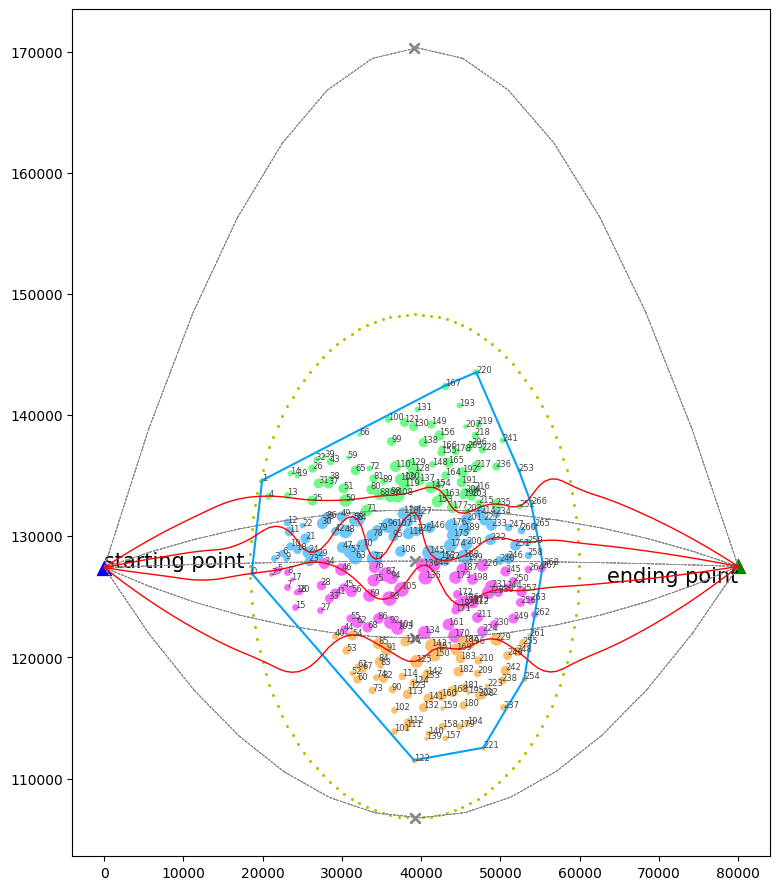

In [9]:
imp.reload(ZoningProblem)
from ZoningProblem import ZoningSolution, ZoningAlgorithm, RoutingAlgorithm
imp.reload(MissionScenario)
from MissionScenario import MissionScenario as Scenario

r_algo = RoutingAlgorithm(scenario)
[smooth_routes, routes, dropped_angles, routes_taskset] = r_algo.search()
print("dropped tasks/angles:", dropped_angles)

#=====================================
# SHOW PATHS
#=====================================
for i in range(1, scenario.nb_agents+1):
  
  '''
  # plot original route
  cx, cy = zip(*routes[i-1])
  cx, cy = np.r_[cx], np.r_[cy]
  ax.plot(cx, cy, c='g', linewidth=1)
  '''

  # plot smoothed routes
  cx, cy = zip(*smooth_routes[i-1])
  cx, cy = np.r_[cx], np.r_[cy]
  ax.plot(cx, cy, c='r', linewidth=1)

for da in dropped_angles:
  print(da)
  ax.text(da[0][0], da[0][1], '%.2f'%da[1], size=12, zorder=1, color='k')
  ax.scatter(da[0][0], da[0][1], color='k', marker='x', s=50)

#zone_ids = scenario.zoning_sol.zones[i]
#for tid in task_IDs:
#  print(tid)
for route_tasks in routes_taskset:
  print(route_tasks)

#zone = scenario.targets[scenario.zoning_sol.zones[1] ]
for i in range(1,nb_agents+1):
  zone_ids = scenario.zoning_sol.zones[i]


'''
for zone_id, nodes in zoning_sol.zones.items():
  print(zone_id, end=': ')
  for node in nodes:
    p = scenario.priorities[node]
    print(node, end=',')
  print()
'''


plt.show()
#=====================================
fig.savefig('results/scenario'+scenario_id+'-routes.pdf', format='pdf', bbox_inches = 'tight', pad_inches = 0)
fig


{'name': 'DZ', 'gravity_acc': 39.24, 'velocity': 150, 'range-angle': 0.7, 'altitude': 3500}
{'name': 'DZ', 'gravity_acc': 39.24, 'velocity': 150, 'range-angle': 0.7, 'altitude': 3500}
{'name': 'UX', 'gravity_acc': 98.10000000000001, 'velocity': 1000, 'range-angle': 0.35, 'altitude': 5500}
{'name': 'DZ', 'gravity_acc': 39.24, 'velocity': 150, 'range-angle': 0.7, 'altitude': 3500}


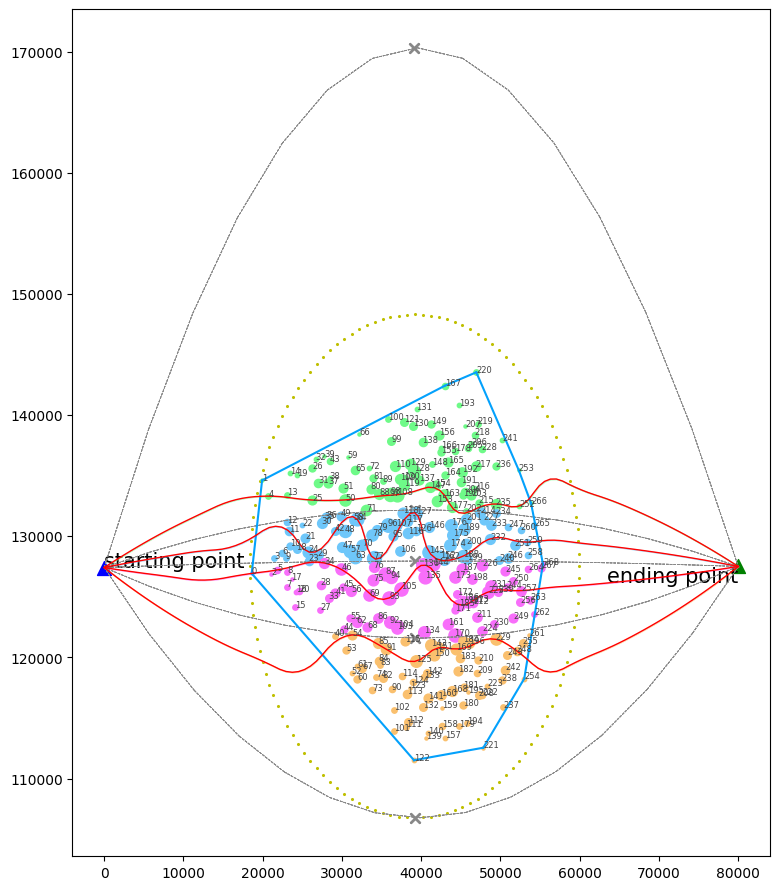

In [10]:
## PATHS
for i in range(1, scenario.nb_agents+1):

  profile = scenario.agents[i-1]
  print(profile)
  A = profile['altitude']
  R_angle = profile['range-angle']
  B = A*np.tan(R_angle)
  b = B/1000
  
  colour = hexcolours[i]
  # plot original route
  cx, cy = zip(*smooth_routes[i-1])
  cx, cy = np.r_[cx], np.r_[cy]
  #ax.plot(cx, cy, c='g', linewidth=1)
  ax.fill_between(cx, cy-b, cy+b, alpha=0.4, color=colour)

plt.show()
fig


### Useful links:

- https://www.quora.com/Is-it-possible-to-generate-random-points-within-a-given-rotated-ellipse-without-using-rejection-sampling
- https://math.stackexchange.com/questions/3710402/generate-random-points-on-perimeter-of-ellipse
- https://cran.r-project.org/web/packages/SIBER/vignettes/Points-Inside-Outside-Ellipse.html
- https://en.wikipedia.org/wiki/Ellipse
- https://stackoverflow.com/questions/5529148/algorithm-calculate-pseudo-random-point-inside-an-ellipse
- https://slidetodoc.com/the-orienteering-problem-a-survey-2011-pieter-vansteenwegen/
- https://en.wikipedia.org/wiki/Standard_rate_turn

### From Fabian:

- 270 m/s = 520 kts = ~ 0.8 Mach
- Valid Sector (range angle): e.g. 45 - 135 and 225 - 315 not 360


### Cruise Speed:

A load factor of one, or 1 g, represents conditions in straight and level flight, where the lift is equal to the weight. Load factors greater or less than one (or even negative) are the result of maneuvers or wind gusts
